# YOLOV8 Experiments

- **Objective**: Evaluate the performance of the YOLOv8 model across different training epochs.
- **Variable Parameters**:
  - Epochs (48, 64, and 100)
  - Batch size (16, 32)
  (default parameters as defined in [Ultralytics documentation](https://docs.ultralytics.com/modes/train/#train-settings))
- **Dataset**:
  - Traffic and Road Signs
    https://universe.roboflow.com/usmanchaudhry622-gmail-com/traffic-and-road-signs
  - Provided by a Roboflow user
  - License: CC BY 4.0

- **Metrics Tracked**:
  - **Training**: Precision, Recall, mAP (mean Average Precision), mAP50
  - **Validation**: mAP, mAP50, mAP75
  - **System metrics**: GPU utilization, memory utlization, time to train
- **Tracking Tool**: [MLflow](https://mlflow.org/) for capturing and logging key metrics.

#### I. Import Data and Dependencies

In [ ]:
!pip install psutil
!pip install pynvml
!pip install --upgrade ultralytics --quiet
!pip install roboflow --quiet
!pip install mlflow --quiet

In [2]:
import os
from pathlib import Path
import random
from PIL import Image
import mlflow
import mlflow.pytorch
import ultralytics
from ultralytics import YOLO, RTDETR, settings
import psutil
import pynvml
from roboflow import Roboflow
from getpass import getpass
from glob import glob
from yolov8 import YOLOV8
from rtdetr import RTDETR_L
import json
from IPython.display import Image, display

import warnings
warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
base_dir = Path(__file__).resolve().parent.parent
dataset_path = base_dir / 'dataset'

In [ ]:
train_images = dataset_path / 'train'
valid_images = dataset_path / 'valid'
test_images = dataset_path / 'test'

print(f"Number of images in train set: {len(list(train_images.glob('*')))}")
print(f"Number of images in validation set: {len(list(valid_images.glob('*')))}")
print(f"Number of images in test set: {len(list(test_images.glob('*')))}")

Number of images in train set: 7092
Number of images in validation set: 1884
Number of images in test set: 1024


In [ ]:
data = '/content/datasets/Traffic-and-Road-Signs-1/data.yaml'

#### II. MLflow Configuration and Tracking

In [7]:
# Set public URI for MLFlow tracking on DAGsHub
os.environ['MLFLOW_TRACKING_USERNAME'] = input('Enter your DAGsHub username: ')
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token: ')
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = input('Enter your DAGsHub project name: ')

Enter your DAGsHub username: shefali.0695
Enter your DAGsHub access token: ··········
Enter your DAGsHub project name: Object-detection-using-YOLOv8-and-RT-DETR


In [ ]:
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow'
mlflow.set_tracking_uri(os.getenv('MLFLOW_TRACKING_URI'))

print("Current MLflow tracking URI:", mlflow.get_tracking_uri())

Current MLflow tracking URI: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow


In [ ]:
# Update Ultralytics setting to enable tracking on MLflow
settings.update({"mlflow": True})

#### III. Baseline model

In [9]:
baseline_model = YOLO("yolov8n.pt")

In [10]:
baseline_model_metrics = baseline_model.val(data=data, imgsz=416, split = 'test', plots=True)

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 58.8MB/s]
val: Scanning /content/datasets/Traffic-and-Road-Signs-1/test/labels... 1024 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1024/1024 [00:00<00:00, 1370.99it/s]

val: New cache created: /content/datasets/Traffic-and-Road-Signs-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.68it/s]


                   all       1024       1024      0.293      0.193      0.181     0.0996
                   cat         71         71      0.121      0.549      0.152     0.0413
              elephant        140        140          0          0          0          0
                  bear        813        813      0.758     0.0308      0.392      0.257
Speed: 0.3ms preprocess, 2.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val


In [11]:
print("YOLOv8 Baseline Model (pre-trained) - Test Metrics")
print("-" * 40)
print(f"mAP (50-95): {baseline_model_metrics.box.map:.4f}")
print(f"mAP50: {baseline_model_metrics.box.map50:.4f}")
print(f"mAP75: {baseline_model_metrics.box.map75:.4f}")


YOLOv8 Baseline Model (pre-trained) - Test Metrics
----------------------------------------
mAP (50-95): 0.0996
mAP50: 0.1812
mAP75: 0.1235


#### IV. Experiment 1: Training with 48 Epochs

- **Project Name**: yolov8_project
- **Run Name**: yolov8_experiment_1
- **Training Parameters**:
  - **Data**: data
  - **Epochs**: 48
  - **Image Size (imgsz)**: 416
  - **Batch Size**: 16
  - **Save**: True
  - **Cache**: False
  - **Project**: yolov8_project
  - **Name**: yolov8_experiment_1
  - **Exist OK**: True
  - **Optimizer**: auto
  - **Seed**: 43
  - **Resume**: False


In [ ]:
if mlflow.active_run():
  mlflow.end_run()

In [ ]:
mlflow.set_experiment("yolov8_project")

<Experiment: artifact_location='mlflow-artifacts:/63672ef888a3488594cd09917737a7b2', creation_time=1724410911984, experiment_id='4', last_update_time=1724410911984, lifecycle_stage='active', name='yolov8_project', tags={}>

In [ ]:
train_params = {
    "data": data,
    "epochs": 48,
    "imgsz": 416,
    "batch": 16,
    "save": False,
    "cache": True,
    "project": "yolov8_project",
    "name": "yolov8_experiment_1",
    "exist_ok": True,
    "optimizer": "auto",
    "seed": 43,
    "resume": False
}

In [ ]:
val_params = {
    "batch": 16,
    "imgsz": 416,
}

In [ ]:
mlflow.system_metrics.enable_system_metrics_logging()

In [ ]:
best_model_path = '/content/yolov8_project/yolov8_experiment_1/weights/best.pt'
export_path = '/content/yolov8_project/yolov8_experiment_1/weights/best.onnx'

In [ ]:
model_experiment1 = YOLOV8(model_path="yolov8n.pt")

In [ ]:
model_experiment1.run(
    train_kwargs=train_params,
    best_model_path=best_model_path,
    val_kwargs=val_params,
    export_format="onnx",
    export_path=export_path,
    run_name="yolov8_experiment_1"
)

2024/08/23 11:45:02 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/Traffic-and-Road-Signs-1/data.yaml, epochs=48, time=None, patience=100, batch=16, imgsz=416, save=False, save_period=-1, cache=True, device=None, workers=8, project=yolov8_project, name=yolov8_experiment_1, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_c

train: Scanning /content/datasets/Traffic-and-Road-Signs-1/train/labels.cache... 7092 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7092/7092 [00:00<?, ?it/s]
train: Caching images (3.4GB RAM): 100%|██████████| 7092/7092 [00:08<00:00, 831.35it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/Traffic-and-Road-Signs-1/valid/labels.cache... 1884 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1884/1884 [00:00<?, ?it/s]
val: Caching images (0.9GB RAM): 100%|██████████| 1884/1884 [00:03<00:00, 547.86it/s]


Plotting labels to yolov8_project/yolov8_experiment_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000303, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/08/23 11:45:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/08/23 11:45:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/08/23 11:45:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(b9a6aa34ea2343fd8a2b5a935c4ef98e) to https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to yolov8_project/yolov8_experiment_1
Starting training for 48 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/48      1.23G      0.944      2.519      1.223         10        416: 100%|██████████| 444/444 [01:21<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.12it/s]

                   all       1884       1886      0.366      0.346      0.273      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/48      1.08G     0.7901      1.193      1.102         12        416: 100%|██████████| 444/444 [01:13<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.51it/s]

                   all       1884       1886      0.454      0.641      0.524      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/48      1.07G     0.7283     0.9503       1.07          9        416: 100%|██████████| 444/444 [01:13<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.31it/s]

                   all       1884       1886      0.632       0.71      0.712      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/48      1.08G     0.6658     0.8018      1.039         11        416: 100%|██████████| 444/444 [01:12<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.13it/s]

                   all       1884       1886      0.622      0.786      0.744      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/48      1.07G     0.6263     0.7153      1.021         12        416: 100%|██████████| 444/444 [01:12<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.44it/s]

                   all       1884       1886      0.724       0.75      0.755       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/48      1.07G     0.5834     0.6401      1.002         10        416: 100%|██████████| 444/444 [01:11<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.52it/s]

                   all       1884       1886      0.699      0.821      0.775      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/48      1.07G     0.5562     0.5861     0.9907         12        416: 100%|██████████| 444/444 [01:12<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.80it/s]

                   all       1884       1886      0.721      0.855      0.796      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/48      1.08G     0.5292     0.5461     0.9809         16        416: 100%|██████████| 444/444 [01:13<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.25it/s]

                   all       1884       1886      0.805      0.857      0.849      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/48      1.08G     0.5131     0.5129     0.9717         13        416: 100%|██████████| 444/444 [01:13<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.16it/s]

                   all       1884       1886       0.79      0.828      0.806      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/48      1.07G     0.4995     0.4916     0.9723          9        416: 100%|██████████| 444/444 [01:14<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.09it/s]

                   all       1884       1886      0.776      0.835      0.808      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/48      1.08G     0.4825     0.4631     0.9625         10        416: 100%|██████████| 444/444 [01:14<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.77it/s]

                   all       1884       1886      0.876      0.842      0.886      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/48      1.07G     0.4757     0.4493     0.9611         11        416: 100%|██████████| 444/444 [01:13<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.63it/s]

                   all       1884       1886      0.754       0.87      0.815      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/48      1.07G     0.4634     0.4342     0.9586         10        416: 100%|██████████| 444/444 [01:12<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.61it/s]

                   all       1884       1886      0.743      0.899      0.845      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/48      1.07G     0.4556     0.4248     0.9561          9        416: 100%|██████████| 444/444 [01:11<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.51it/s]

                   all       1884       1886      0.754      0.892      0.839      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/48      1.07G     0.4486      0.412     0.9535         11        416: 100%|██████████| 444/444 [01:12<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.42it/s]

                   all       1884       1886      0.866      0.857      0.888      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/48      1.07G     0.4388     0.3952     0.9493          7        416: 100%|██████████| 444/444 [01:12<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.21it/s]

                   all       1884       1886      0.783      0.821      0.794      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/48      1.07G     0.4284     0.3831     0.9459          8        416: 100%|██████████| 444/444 [01:11<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.46it/s]

                   all       1884       1886      0.858      0.845      0.888      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/48      1.07G     0.4221     0.3803     0.9442          7        416: 100%|██████████| 444/444 [01:11<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.32it/s]

                   all       1884       1886      0.861      0.857      0.884      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/48      1.07G     0.4155     0.3682      0.941         15        416: 100%|██████████| 444/444 [01:12<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.53it/s]

                   all       1884       1886      0.798      0.878      0.858      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/48      1.07G     0.4099      0.366     0.9401         11        416: 100%|██████████| 444/444 [01:11<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.47it/s]

                   all       1884       1886      0.892      0.877      0.894      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/48      1.07G     0.4034     0.3521     0.9389         11        416: 100%|██████████| 444/444 [01:12<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.31it/s]

                   all       1884       1886      0.837      0.862      0.884      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/48      1.07G     0.3997     0.3522     0.9364         11        416: 100%|██████████| 444/444 [01:11<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.49it/s]

                   all       1884       1886      0.808      0.893      0.882      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/48      1.08G     0.3928     0.3475     0.9375          9        416: 100%|██████████| 444/444 [01:13<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.06it/s]

                   all       1884       1886      0.891       0.88      0.898      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/48      1.07G     0.3912     0.3413     0.9342          7        416: 100%|██████████| 444/444 [01:14<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.46it/s]

                   all       1884       1886        0.9      0.879      0.909      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/48      1.07G     0.3815     0.3341      0.934         11        416: 100%|██████████| 444/444 [01:14<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  6.59it/s]

                   all       1884       1886      0.734      0.888       0.81      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/48      1.07G     0.3754     0.3298     0.9296         10        416: 100%|██████████| 444/444 [01:15<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  6.64it/s]

                   all       1884       1886       0.83      0.898      0.898      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/48      1.08G     0.3733     0.3271     0.9306         13        416: 100%|██████████| 444/444 [01:15<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  6.69it/s]

                   all       1884       1886      0.841      0.888      0.894      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/48      1.07G     0.3674     0.3137     0.9274         13        416: 100%|██████████| 444/444 [01:14<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.39it/s]

                   all       1884       1886      0.838      0.894      0.899      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/48      1.08G     0.3657     0.3169     0.9287         10        416: 100%|██████████| 444/444 [01:15<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.10it/s]

                   all       1884       1886      0.818       0.88      0.863      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/48      1.07G     0.3601     0.3133     0.9245          6        416: 100%|██████████| 444/444 [01:14<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.64it/s]

                   all       1884       1886      0.843      0.886      0.899      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/48      1.07G     0.3541     0.3052     0.9223          9        416: 100%|██████████| 444/444 [01:13<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]

                   all       1884       1886      0.838      0.871      0.878      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/48      1.08G     0.3531      0.301     0.9205          8        416: 100%|██████████| 444/444 [01:12<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.33it/s]

                   all       1884       1886      0.862      0.871      0.893      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/48      1.07G     0.3501      0.296     0.9228          9        416: 100%|██████████| 444/444 [01:12<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.58it/s]

                   all       1884       1886       0.85      0.878      0.885      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/48      1.07G     0.3458     0.2942     0.9201          8        416: 100%|██████████| 444/444 [01:13<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.47it/s]

                   all       1884       1886      0.863      0.883       0.89      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/48      1.07G     0.3372     0.2826     0.9184          9        416: 100%|██████████| 444/444 [01:13<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.71it/s]

                   all       1884       1886      0.892      0.891      0.913      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/48      1.08G     0.3368      0.287     0.9162         13        416: 100%|██████████| 444/444 [01:13<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.83it/s]

                   all       1884       1886      0.877      0.885      0.914      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/48      1.07G     0.3326     0.2794     0.9163         11        416: 100%|██████████| 444/444 [01:14<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.47it/s]

                   all       1884       1886      0.892      0.907      0.912      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/48      1.07G     0.3301     0.2783      0.915         14        416: 100%|██████████| 444/444 [01:14<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  6.64it/s]

                   all       1884       1886      0.884      0.898      0.904      0.755


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/48      1.21G     0.5743     0.4127      1.089          4        416: 100%|██████████| 444/444 [01:13<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.42it/s]

                   all       1884       1886      0.874      0.919       0.91      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/48      1.07G     0.5521     0.3266       1.07          4        416: 100%|██████████| 444/444 [01:10<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.71it/s]

                   all       1884       1886      0.898      0.913      0.917      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/48      1.07G     0.5385     0.3005      1.065          4        416: 100%|██████████| 444/444 [01:10<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.50it/s]

                   all       1884       1886      0.902      0.917       0.92      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/48      1.07G     0.5405     0.2869      1.057          4        416: 100%|██████████| 444/444 [01:10<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.50it/s]

                   all       1884       1886      0.913      0.919      0.927      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/48      1.07G      0.532     0.2689      1.053          4        416: 100%|██████████| 444/444 [01:08<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.88it/s]

                   all       1884       1886      0.921      0.925      0.926      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/48      1.07G     0.5313     0.2596      1.053          4        416: 100%|██████████| 444/444 [01:10<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  6.65it/s]

                   all       1884       1886      0.918      0.927      0.923      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/48      1.07G     0.5223      0.248       1.05          4        416: 100%|██████████| 444/444 [01:10<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.66it/s]

                   all       1884       1886      0.918      0.933      0.923      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/48      1.07G     0.5161     0.2414      1.046          4        416: 100%|██████████| 444/444 [01:09<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.42it/s]

                   all       1884       1886       0.92      0.934      0.928       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/48      1.07G     0.5123     0.2396      1.044          4        416: 100%|██████████| 444/444 [01:09<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.32it/s]

                   all       1884       1886      0.922      0.936      0.924      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/48      1.07G     0.5159     0.2331      1.043          4        416: 100%|██████████| 444/444 [01:10<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.89it/s]

                   all       1884       1886      0.923      0.937      0.925      0.791



48 epochs completed in 1.120 hours.
Optimizer stripped from yolov8_project/yolov8_experiment_1/weights/last.pt, 6.2MB
Optimizer stripped from yolov8_project/yolov8_experiment_1/weights/best.pt, 6.2MB

Validating yolov8_project/yolov8_experiment_1/weights/best.pt...
Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,011,303 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.06it/s]


                   all       1884       1886      0.923      0.937      0.925      0.791
-Road narrows on right         54         54      0.976          1      0.995      0.883
    50 mph speed limit         62         62       0.46          1      0.613      0.502
     Attention Please-        117        117      0.997          1      0.995      0.857
    Beware of children        106        106          1      0.986      0.995      0.889
CYCLE ROUTE AHEAD WARNING         54         54      0.993          1      0.995      0.863
Dangerous Left Curve Ahead         42         42          1      0.983      0.995      0.863
Dangerous Rright Curve Ahead         72         72       0.98          1      0.995      0.832
End of all speed and passing limits         48         48      0.994          1      0.995      0.822
              Give Way        107        107      0.996          1      0.995      0.849
Go Straight or Turn Right         79         79       0.98      0.987      0.995    

2024/08/23 12:53:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run yolov8_experiment_1 at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4/runs/b9a6aa34ea2343fd8a2b5a935c4ef98e.
2024/08/23 12:53:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4.
2024/08/23 12:53:25 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/08/23 12:53:26 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


MLflow: results logged to https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow
MLflow: disable with 'yolo settings mlflow=False'


2024/08/23 12:53:26 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/08/23 12:53:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run bittersweet-asp-239 at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4/runs/38ffd5f3b5424fc1bcfe825c7a63b8ba.
2024/08/23 12:53:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4.
2024/08/23 12:53:27 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/08/23 12:53:27 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,011,303 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/datasets/Traffic-and-Road-Signs-1/valid/labels.cache... 1884 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1884/1884 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:14<00:00,  8.22it/s]


                   all       1884       1886      0.923      0.937      0.925       0.79
-Road narrows on right         54         54      0.976          1      0.995      0.881
    50 mph speed limit         62         62       0.46          1      0.612      0.503
     Attention Please-        117        117      0.997          1      0.995      0.857
    Beware of children        106        106          1      0.986      0.995      0.887
CYCLE ROUTE AHEAD WARNING         54         54      0.993          1      0.995      0.862
Dangerous Left Curve Ahead         42         42          1      0.983      0.995      0.863
Dangerous Rright Curve Ahead         72         72       0.98          1      0.995      0.835
End of all speed and passing limits         48         48      0.994          1      0.995      0.822
              Give Way        107        107      0.996          1      0.995      0.851
Go Straight or Turn Right         79         79       0.98      0.987      0.995    

2024/08/23 12:53:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/content/yolov8_project/yolov8_experiment_1/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 33, 3549) (5.9 MB)

ONNX: starting export with onnx 1.16.2 opset 17...
ONNX: export success ✅ 0.7s, saved as '/content/yolov8_project/yolov8_experiment_1/weights/best.onnx' (11.6 MB)

Export complete (2.1s)
Results saved to /content/yolov8_project/yolov8_experiment_1/weights
Predict:         yolo predict task=detect model=/content/yolov8_project/yolov8_experiment_1/weights/best.onnx imgsz=416  
Validate:        yolo val task=detect model=/content/yolov8_project/yolov8_experiment_1/weights/best.onnx imgsz=416 data=/content/datasets/Traffic-and-Road-Signs-1/data.yaml  
Visualize:       https://netron.app


2024/08/23 12:53:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run blushing-lynx-998 at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4/runs/022dc4cbfff3476a899667ce576e4f60.
2024/08/23 12:53:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4.
2024/08/23 12:53:50 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/08/23 12:53:51 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


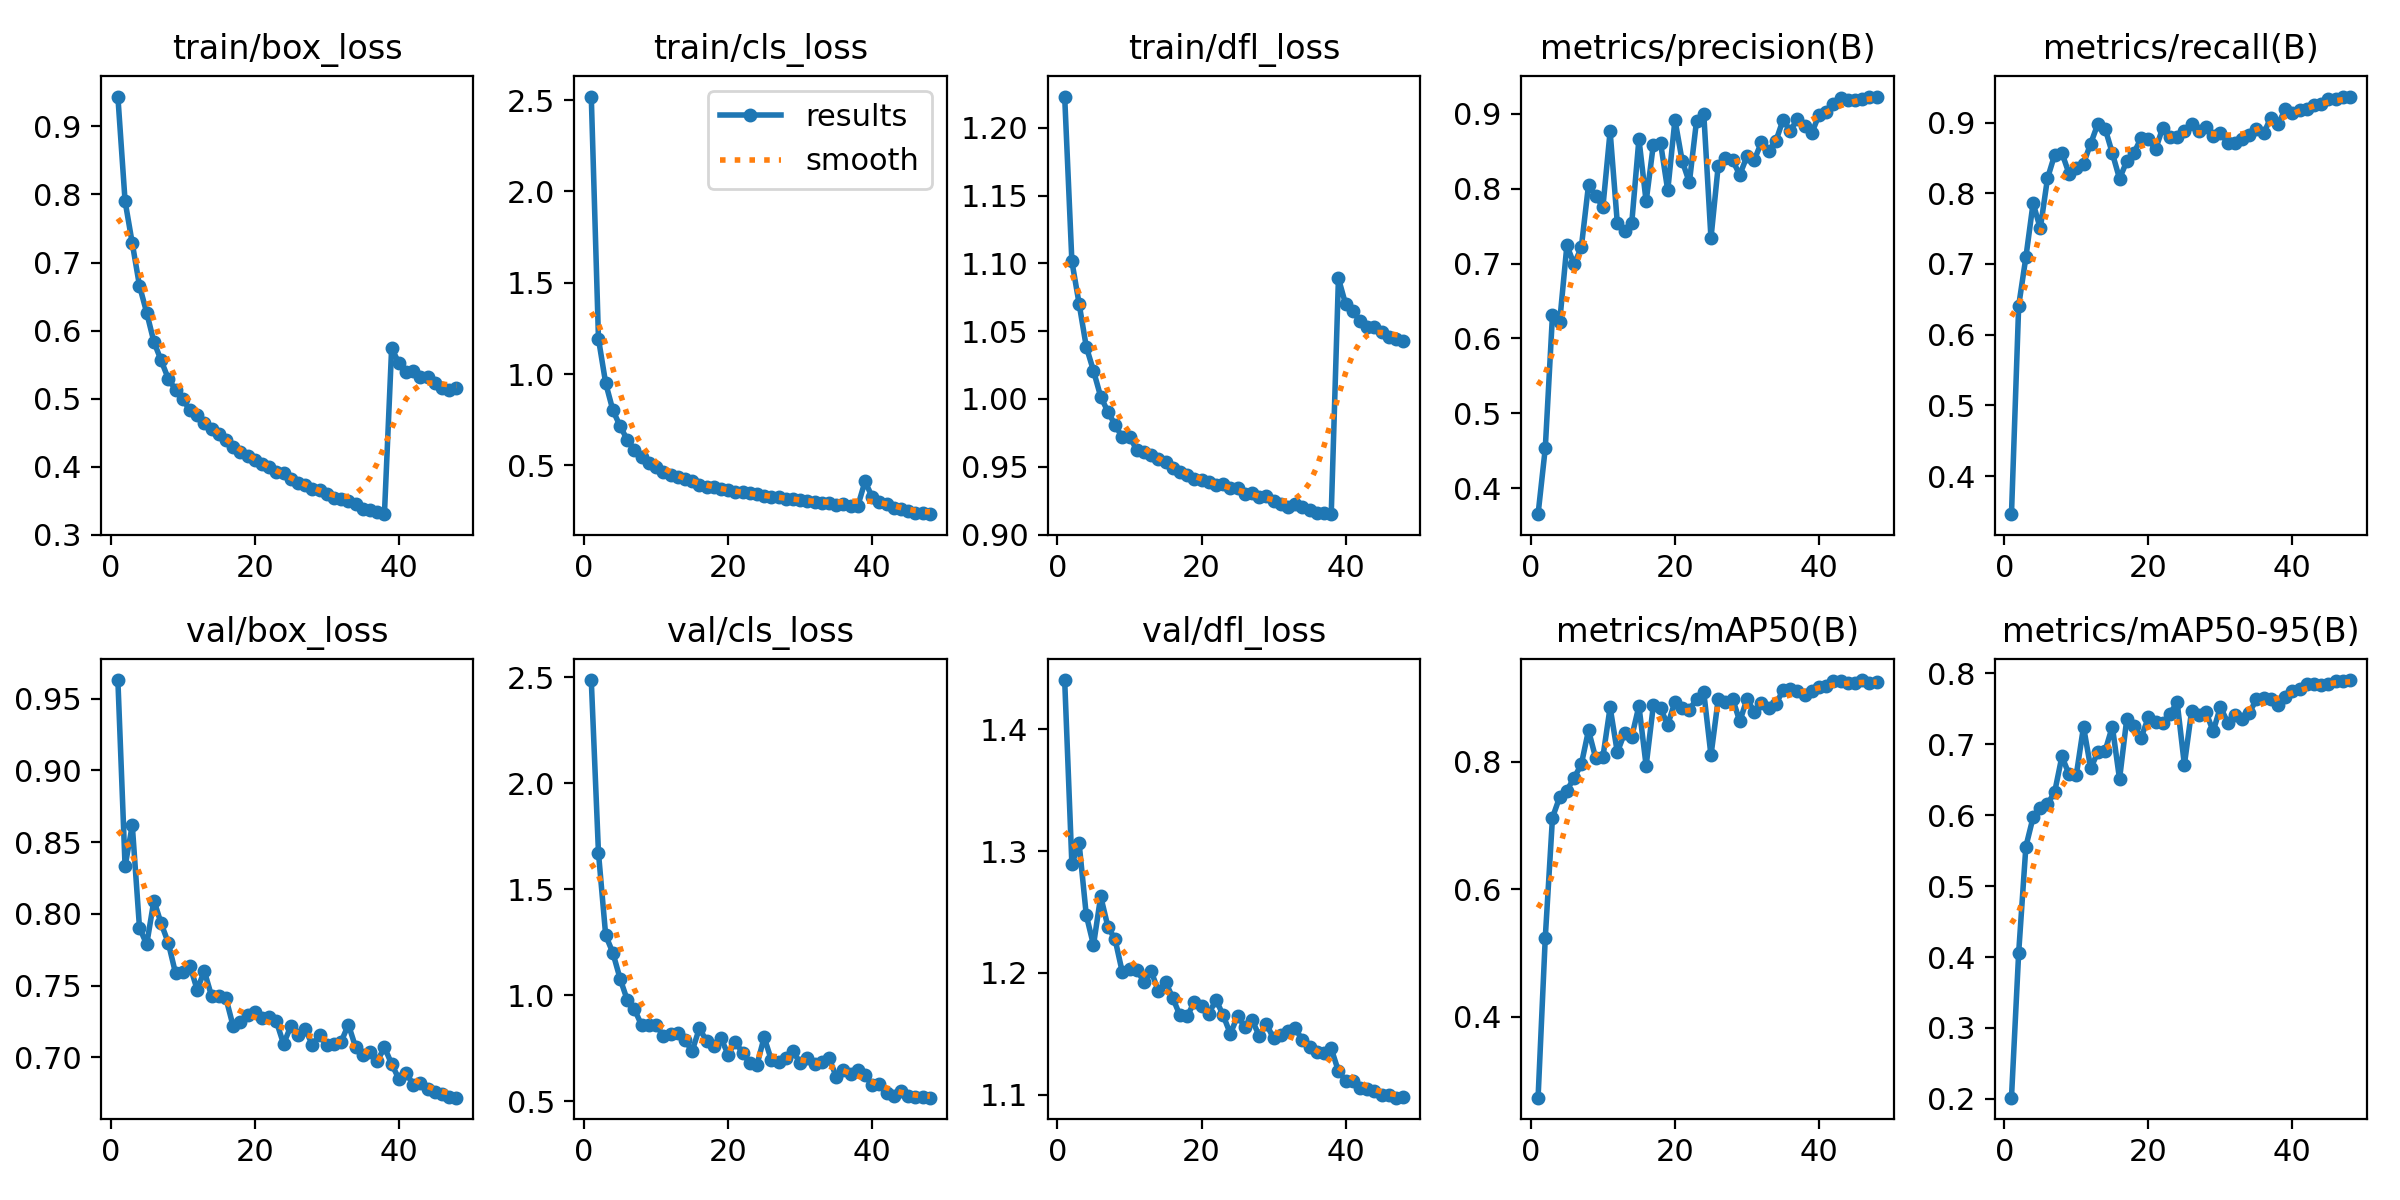

In [16]:
# Training results - visualized
image_path = '/content/datasets/results_yolov8_1.png'
display(Image(filename=image_path))

##### Evaluate performance on test set

In [ ]:
# Check performance on test set
best_model_yolov8_experiment_1 = YOLO('/content/yolov8_project/yolov8_experiment_1/weights/best.pt')

In [ ]:
yolov8_experiment_1_test_metrics = best_model_yolov8_experiment_1.val(data=data, imgsz=416, split = 'test', plots=True)

Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,011,303 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/datasets/Traffic-and-Road-Signs-1/test/labels... 1024 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1024/1024 [00:00<00:00, 1438.36it/s]

val: New cache created: /content/datasets/Traffic-and-Road-Signs-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:11<00:00,  5.70it/s]


                   all       1024       1024      0.271      0.252       0.28       0.23
        No_Over_Taking         71         71          0          0          0          0
   Speed Limit 20 KMPh        140        140      0.812      0.757       0.84      0.691
   Speed Limit 30 KMPh        813        813          0          0          0          0
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val3


In [15]:
print("YOLOv8 Experiment 1 - Test Metrics")
print("-" * 40)
print(f"mAP (50-95): {yolov8_experiment_1_test_metrics.box.map:.4f}")
print(f"mAP50: {yolov8_experiment_1_test_metrics.box.map50:.4f}")
print(f"mAP75: {yolov8_experiment_1_test_metrics.box.map75:.4f}")
print(f"Mean Precision: {yolov8_experiment_1_test_metrics.box.mp: 4f}")
print(f"Mean Recall: {yolov8_experiment_1_test_metrics.box.mr: 4f}")

YOLOv8 Experiment 1 - Test Metrics
----------------------------------------
mAP (50-95): 0.2302
mAP50: 0.2800
mAP75: 0.2767
Mean Precision:  0.270550
Mean Recall:  0.252381


#### V. Experiment 2: Training with 64 Epochs

- **Project Name**: yolov8_project
- **Run Name**: yolov8_experiment_2
- **Training Parameters**:
  - **Data**: data
  - **Epochs**: 64
  - **Image Size (imgsz)**: 416
  - **Batch Size**: 16
  - **Save**: True
  - **Cache**: False
  - **Project**: yolov8_project
  - **Name**: yolov8_experiment_2
  - **Exist OK**: True
  - **Optimizer**: auto
  - **Seed**: 43
  - **Resume**: False

In [ ]:
if mlflow.active_run():
  mlflow.end_run()

In [ ]:
mlflow.set_experiment("yolov8_project")

<Experiment: artifact_location='mlflow-artifacts:/63672ef888a3488594cd09917737a7b2', creation_time=1724410911984, experiment_id='4', last_update_time=1724410911984, lifecycle_stage='active', name='yolov8_project', tags={}>

In [ ]:
train_params = {
    "data": data,
    "epochs": 64,
    "imgsz": 416,
    "batch": 16,
    "save": True,
    "cache": False,
    "project": "yolov8_project",
    "name": "yolov8_experiment_2",
    "exist_ok": True,
    "optimizer": "auto",
    "seed": 43,
    "resume": False
}

In [ ]:
val_params = {
    "imgsz": 416,
}

In [ ]:
mlflow.system_metrics.enable_system_metrics_logging()

In [ ]:
best_model_path = '/content/yolov8_project/yolov8_experiment_2/weights/best.pt'
export_path = '/content/yolov8_project/yolov8_experiment_2/weights/best.onnx'

In [ ]:
model_experiment2 = YOLOV8(model_path="yolov8n.pt")

In [ ]:
model_experiment2.run(
    train_kwargs=train_params,
    best_model_path=best_model_path,
    val_kwargs=val_params,
    export_format="onnx",
    export_path=export_path,
    run_name="yolov8_experiment_2"
)

2024/08/23 15:53:39 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/Traffic-and-Road-Signs-1/data.yaml, epochs=64, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov8_project, name=yolov8_experiment_2, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_c

train: Scanning /content/datasets/Traffic-and-Road-Signs-1/train/labels.cache... 7092 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7092/7092 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/Traffic-and-Road-Signs-1/valid/labels.cache... 1884 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1884/1884 [00:00<?, ?it/s]


Plotting labels to yolov8_project/yolov8_experiment_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000303, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/08/23 15:53:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/08/23 15:53:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/08/23 15:53:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(60262e5cebf7458fac5bd0b84a48cd31) to https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to yolov8_project/yolov8_experiment_2
Starting training for 64 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/64      1.23G     0.9558        3.4      1.307         13        416: 100%|██████████| 444/444 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.10it/s]

                   all       1884       1886      0.419      0.533      0.391      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/64      1.08G     0.8525      2.009       1.23         11        416: 100%|██████████| 444/444 [01:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.07it/s]

                   all       1884       1886      0.753      0.752       0.75      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/64      1.08G     0.8177      1.495       1.19          8        416: 100%|██████████| 444/444 [01:19<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.39it/s]

                   all       1884       1886      0.744      0.808      0.782      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/64      1.08G      0.789      1.268      1.151         13        416: 100%|██████████| 444/444 [01:19<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.26it/s]

                   all       1884       1886      0.728      0.872      0.813      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/64      1.08G     0.7654      1.156      1.127         15        416: 100%|██████████| 444/444 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.54it/s]

                   all       1884       1886      0.803      0.855      0.837      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/64      1.07G     0.7523      1.047      1.116         10        416: 100%|██████████| 444/444 [01:19<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.74it/s]

                   all       1884       1886      0.825      0.868      0.874      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/64      1.07G     0.7442     0.9821      1.108         10        416: 100%|██████████| 444/444 [01:17<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.23it/s]

                   all       1884       1886      0.819      0.886      0.889      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/64      1.07G     0.7405     0.9313        1.1         16        416: 100%|██████████| 444/444 [01:20<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.34it/s]

                   all       1884       1886       0.85      0.879      0.893      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/64      1.07G     0.7296     0.8755      1.092         14        416: 100%|██████████| 444/444 [01:19<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.33it/s]

                   all       1884       1886      0.882      0.875      0.906      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/64      1.08G     0.7224     0.8442      1.089         11        416: 100%|██████████| 444/444 [01:18<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.83it/s]

                   all       1884       1886      0.855      0.913      0.923      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/64      1.08G     0.7146     0.7957      1.083         10        416: 100%|██████████| 444/444 [01:19<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.52it/s]

                   all       1884       1886       0.85      0.932      0.902      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/64      1.08G     0.7171     0.7838      1.084         11        416: 100%|██████████| 444/444 [01:17<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.26it/s]

                   all       1884       1886      0.879      0.917      0.914      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/64      1.08G     0.7143     0.7547      1.083         12        416: 100%|██████████| 444/444 [01:19<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.03it/s]

                   all       1884       1886      0.893      0.901      0.913      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/64      1.07G     0.7129     0.7335      1.082          9        416: 100%|██████████| 444/444 [01:18<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.29it/s]

                   all       1884       1886      0.912      0.903      0.921      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/64      1.07G     0.6999     0.7217      1.078         11        416: 100%|██████████| 444/444 [01:20<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.42it/s]

                   all       1884       1886      0.879      0.916      0.911       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/64      1.07G     0.7053     0.6997      1.078          9        416: 100%|██████████| 444/444 [01:19<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.30it/s]

                   all       1884       1886      0.905      0.922      0.922      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/64      1.07G     0.6987     0.6863      1.075          6        416: 100%|██████████| 444/444 [01:19<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.14it/s]


                   all       1884       1886      0.918       0.92      0.927      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/64      1.07G     0.6945     0.6717      1.073          6        416: 100%|██████████| 444/444 [01:18<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.14it/s]

                   all       1884       1886      0.919      0.918      0.916      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/64      1.07G     0.6882     0.6561      1.071         13        416: 100%|██████████| 444/444 [01:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.38it/s]

                   all       1884       1886      0.924      0.929      0.922      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/64      1.07G      0.689     0.6429      1.067         11        416: 100%|██████████| 444/444 [01:20<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.01it/s]

                   all       1884       1886      0.915      0.931      0.933      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/64      1.07G     0.6874       0.63       1.07         11        416: 100%|██████████| 444/444 [01:21<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.27it/s]

                   all       1884       1886      0.919       0.92       0.92      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/64      1.07G     0.6876      0.627      1.069         12        416: 100%|██████████| 444/444 [01:21<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.12it/s]

                   all       1884       1886      0.915      0.928      0.923      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/64      1.07G     0.6842     0.6125      1.069          9        416: 100%|██████████| 444/444 [01:20<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.47it/s]

                   all       1884       1886      0.906       0.91       0.92      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/64      1.08G     0.6827     0.6055      1.066          9        416: 100%|██████████| 444/444 [01:20<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.21it/s]

                   all       1884       1886      0.918      0.947       0.94      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/64      1.08G     0.6793     0.5903      1.062         11        416: 100%|██████████| 444/444 [01:19<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.15it/s]


                   all       1884       1886      0.933      0.923      0.924      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/64      1.07G     0.6824     0.5953      1.067         11        416: 100%|██████████| 444/444 [01:19<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.29it/s]

                   all       1884       1886      0.918      0.931      0.922      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/64      1.07G     0.6745     0.5807      1.063         14        416: 100%|██████████| 444/444 [01:20<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.29it/s]

                   all       1884       1886      0.915      0.919      0.917       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/64      1.07G     0.6732     0.5711      1.061         11        416: 100%|██████████| 444/444 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.34it/s]

                   all       1884       1886      0.922       0.93      0.929      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/64      1.07G     0.6713     0.5717      1.064         13        416: 100%|██████████| 444/444 [01:17<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.58it/s]

                   all       1884       1886      0.925      0.935      0.925      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/64      1.07G     0.6668     0.5538       1.06          6        416: 100%|██████████| 444/444 [01:20<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.54it/s]

                   all       1884       1886      0.938      0.928      0.923      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/64      1.07G     0.6703     0.5585      1.059          9        416: 100%|██████████| 444/444 [01:17<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]

                   all       1884       1886      0.924      0.927      0.923      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/64      1.07G     0.6694     0.5554      1.055          8        416: 100%|██████████| 444/444 [01:21<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.03it/s]

                   all       1884       1886      0.926      0.925       0.92      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/64      1.07G     0.6724     0.5452      1.062          9        416: 100%|██████████| 444/444 [01:19<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.20it/s]

                   all       1884       1886      0.969      0.945       0.93      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/64      1.07G     0.6659     0.5364      1.057          8        416: 100%|██████████| 444/444 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.44it/s]

                   all       1884       1886      0.966      0.927       0.92      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/64      1.07G     0.6593     0.5234      1.054         10        416: 100%|██████████| 444/444 [01:19<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.48it/s]

                   all       1884       1886       0.92      0.945      0.927      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/64      1.07G     0.6606     0.5227      1.053         12        416: 100%|██████████| 444/444 [01:21<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.76it/s]

                   all       1884       1886      0.961      0.938      0.926      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/64      1.07G     0.6624     0.5163      1.054         10        416: 100%|██████████| 444/444 [01:18<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.15it/s]

                   all       1884       1886      0.969      0.937      0.925      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/64      1.07G     0.6527     0.5101      1.051         11        416: 100%|██████████| 444/444 [01:20<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.87it/s]

                   all       1884       1886       0.97      0.936      0.929      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/64      1.07G     0.6548     0.5142      1.053         11        416: 100%|██████████| 444/444 [01:19<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]

                   all       1884       1886      0.935      0.936      0.927      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/64      1.07G     0.6508     0.4996      1.048          7        416: 100%|██████████| 444/444 [01:20<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.74it/s]


                   all       1884       1886      0.933      0.936      0.933      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/64      1.07G     0.6503     0.4947      1.048          8        416: 100%|██████████| 444/444 [01:18<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.59it/s]

                   all       1884       1886      0.977      0.938       0.93       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/64      1.07G     0.6488     0.4931       1.05         11        416: 100%|██████████| 444/444 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.56it/s]

                   all       1884       1886      0.963       0.94      0.926      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/64      1.07G     0.6527     0.4852      1.052         14        416: 100%|██████████| 444/444 [01:18<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.56it/s]

                   all       1884       1886      0.978      0.939      0.929      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/64      1.08G     0.6435     0.4718      1.047         14        416: 100%|██████████| 444/444 [01:20<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.37it/s]

                   all       1884       1886      0.969      0.947       0.93       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/64      1.07G     0.6455     0.4735      1.047          9        416: 100%|██████████| 444/444 [01:19<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.60it/s]

                   all       1884       1886      0.933      0.942       0.93      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/64      1.07G     0.6418     0.4771      1.047         11        416: 100%|██████████| 444/444 [01:20<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.54it/s]

                   all       1884       1886      0.966      0.938      0.927      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/64      1.07G     0.6443     0.4712      1.048         13        416: 100%|██████████| 444/444 [01:19<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.72it/s]

                   all       1884       1886      0.972      0.943      0.931      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/64      1.07G     0.6361     0.4616       1.04          7        416: 100%|██████████| 444/444 [01:21<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.43it/s]

                   all       1884       1886      0.975      0.946      0.936      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/64      1.07G     0.6378     0.4576      1.045         14        416: 100%|██████████| 444/444 [01:21<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.39it/s]

                   all       1884       1886      0.977      0.936      0.927      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/64      1.07G     0.6345     0.4589      1.044         11        416: 100%|██████████| 444/444 [01:20<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]


                   all       1884       1886      0.972      0.944      0.932      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/64      1.07G     0.6338     0.4483      1.042         11        416: 100%|██████████| 444/444 [01:20<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.41it/s]

                   all       1884       1886      0.971      0.941       0.93      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/64      1.07G     0.6321     0.4443      1.039         10        416: 100%|██████████| 444/444 [01:20<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.34it/s]

                   all       1884       1886      0.965      0.945      0.928      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/64      1.07G     0.6282     0.4452      1.041          6        416: 100%|██████████| 444/444 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.36it/s]

                   all       1884       1886      0.975      0.946       0.93      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/64      1.07G     0.6306     0.4396      1.042         11        416: 100%|██████████| 444/444 [01:21<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.20it/s]

                   all       1884       1886      0.974      0.946       0.93      0.794


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/64      1.21G     0.5177     0.2343       1.04          4        416: 100%|██████████| 444/444 [01:16<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.36it/s]

                   all       1884       1886      0.972      0.938       0.93      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/64      1.07G     0.5095     0.2211      1.039          4        416: 100%|██████████| 444/444 [01:17<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.16it/s]

                   all       1884       1886      0.963      0.944      0.934      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/64      1.07G     0.5087     0.2178      1.038          4        416: 100%|██████████| 444/444 [01:18<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.43it/s]

                   all       1884       1886      0.975      0.938      0.932      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/64      1.07G     0.5062     0.2193      1.039          4        416: 100%|██████████| 444/444 [01:16<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  5.91it/s]

                   all       1884       1886      0.968      0.947      0.935      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/64      1.07G     0.5022     0.2132      1.035          4        416: 100%|██████████| 444/444 [01:15<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.32it/s]

                   all       1884       1886      0.969      0.946      0.932      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/64      1.07G     0.4967     0.2097       1.03          4        416: 100%|██████████| 444/444 [01:15<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.21it/s]

                   all       1884       1886      0.969      0.945      0.931      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/64      1.07G     0.4897     0.2059      1.033          4        416: 100%|██████████| 444/444 [01:15<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]

                   all       1884       1886      0.975      0.945      0.932      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/64      1.07G      0.493     0.2048       1.03          4        416: 100%|██████████| 444/444 [01:17<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.06it/s]

                   all       1884       1886      0.972      0.945      0.934      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/64      1.07G     0.4919     0.2023      1.029          4        416: 100%|██████████| 444/444 [01:18<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.44it/s]

                   all       1884       1886       0.97      0.946      0.933      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/64      1.07G     0.4891     0.1998      1.026          4        416: 100%|██████████| 444/444 [01:19<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:10<00:00,  5.78it/s]

                   all       1884       1886      0.968      0.946      0.932      0.802



64 epochs completed in 1.622 hours.
Optimizer stripped from yolov8_project/yolov8_experiment_2/weights/last.pt, 6.2MB
Optimizer stripped from yolov8_project/yolov8_experiment_2/weights/best.pt, 6.2MB

Validating yolov8_project/yolov8_experiment_2/weights/best.pt...
Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,011,303 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:12<00:00,  4.83it/s]


                   all       1884       1886       0.97      0.946      0.933      0.803
-Road narrows on right         54         54      0.999          1      0.995      0.892
    50 mph speed limit         62         62      0.532          1      0.615       0.49
     Attention Please-        117        117          1          1      0.995      0.869
    Beware of children        106        106          1      0.992      0.995      0.894
CYCLE ROUTE AHEAD WARNING         54         54      0.999          1      0.995      0.869
Dangerous Left Curve Ahead         42         42      0.998          1      0.995      0.884
Dangerous Rright Curve Ahead         72         72          1      0.974      0.995      0.848
End of all speed and passing limits         48         48      0.998          1      0.995      0.826
              Give Way        107        107      0.999          1      0.995      0.857
Go Straight or Turn Right         79         79      0.999          1      0.995    

2024/08/23 17:31:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run yolov8_experiment_2 at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4/runs/60262e5cebf7458fac5bd0b84a48cd31.
2024/08/23 17:31:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4.
2024/08/23 17:31:57 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/08/23 17:31:57 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


MLflow: results logged to https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow
MLflow: disable with 'yolo settings mlflow=False'


2024/08/23 17:31:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/08/23 17:31:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run wise-chimp-171 at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4/runs/23952a57a0684da2a3d7f966d0dd5c55.
2024/08/23 17:31:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4.
2024/08/23 17:31:58 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/08/23 17:31:58 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,011,303 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/datasets/Traffic-and-Road-Signs-1/valid/labels.cache... 1884 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1884/1884 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:14<00:00,  8.17it/s]


                   all       1884       1886       0.97      0.946      0.933      0.803
-Road narrows on right         54         54      0.999          1      0.995      0.892
    50 mph speed limit         62         62      0.532          1      0.614       0.49
     Attention Please-        117        117          1          1      0.995      0.868
    Beware of children        106        106          1      0.992      0.995      0.894
CYCLE ROUTE AHEAD WARNING         54         54      0.999          1      0.995      0.869
Dangerous Left Curve Ahead         42         42      0.998          1      0.995      0.884
Dangerous Rright Curve Ahead         72         72          1      0.975      0.995      0.849
End of all speed and passing limits         48         48      0.998          1      0.995      0.824
              Give Way        107        107      0.999          1      0.995      0.857
Go Straight or Turn Right         79         79      0.999          1      0.995    

2024/08/23 17:32:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/content/yolov8_project/yolov8_experiment_2/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 33, 3549) (5.9 MB)

ONNX: starting export with onnx 1.16.2 opset 17...
ONNX: export success ✅ 0.8s, saved as '/content/yolov8_project/yolov8_experiment_2/weights/best.onnx' (11.6 MB)

Export complete (2.1s)
Results saved to /content/yolov8_project/yolov8_experiment_2/weights
Predict:         yolo predict task=detect model=/content/yolov8_project/yolov8_experiment_2/weights/best.onnx imgsz=416  
Validate:        yolo val task=detect model=/content/yolov8_project/yolov8_experiment_2/weights/best.onnx imgsz=416 data=/content/datasets/Traffic-and-Road-Signs-1/data.yaml  
Visualize:       https://netron.app


2024/08/23 17:32:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-shark-741 at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4/runs/652df7f3ca20452b962d063ee6af22a7.
2024/08/23 17:32:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4.
2024/08/23 17:32:22 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/08/23 17:32:22 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


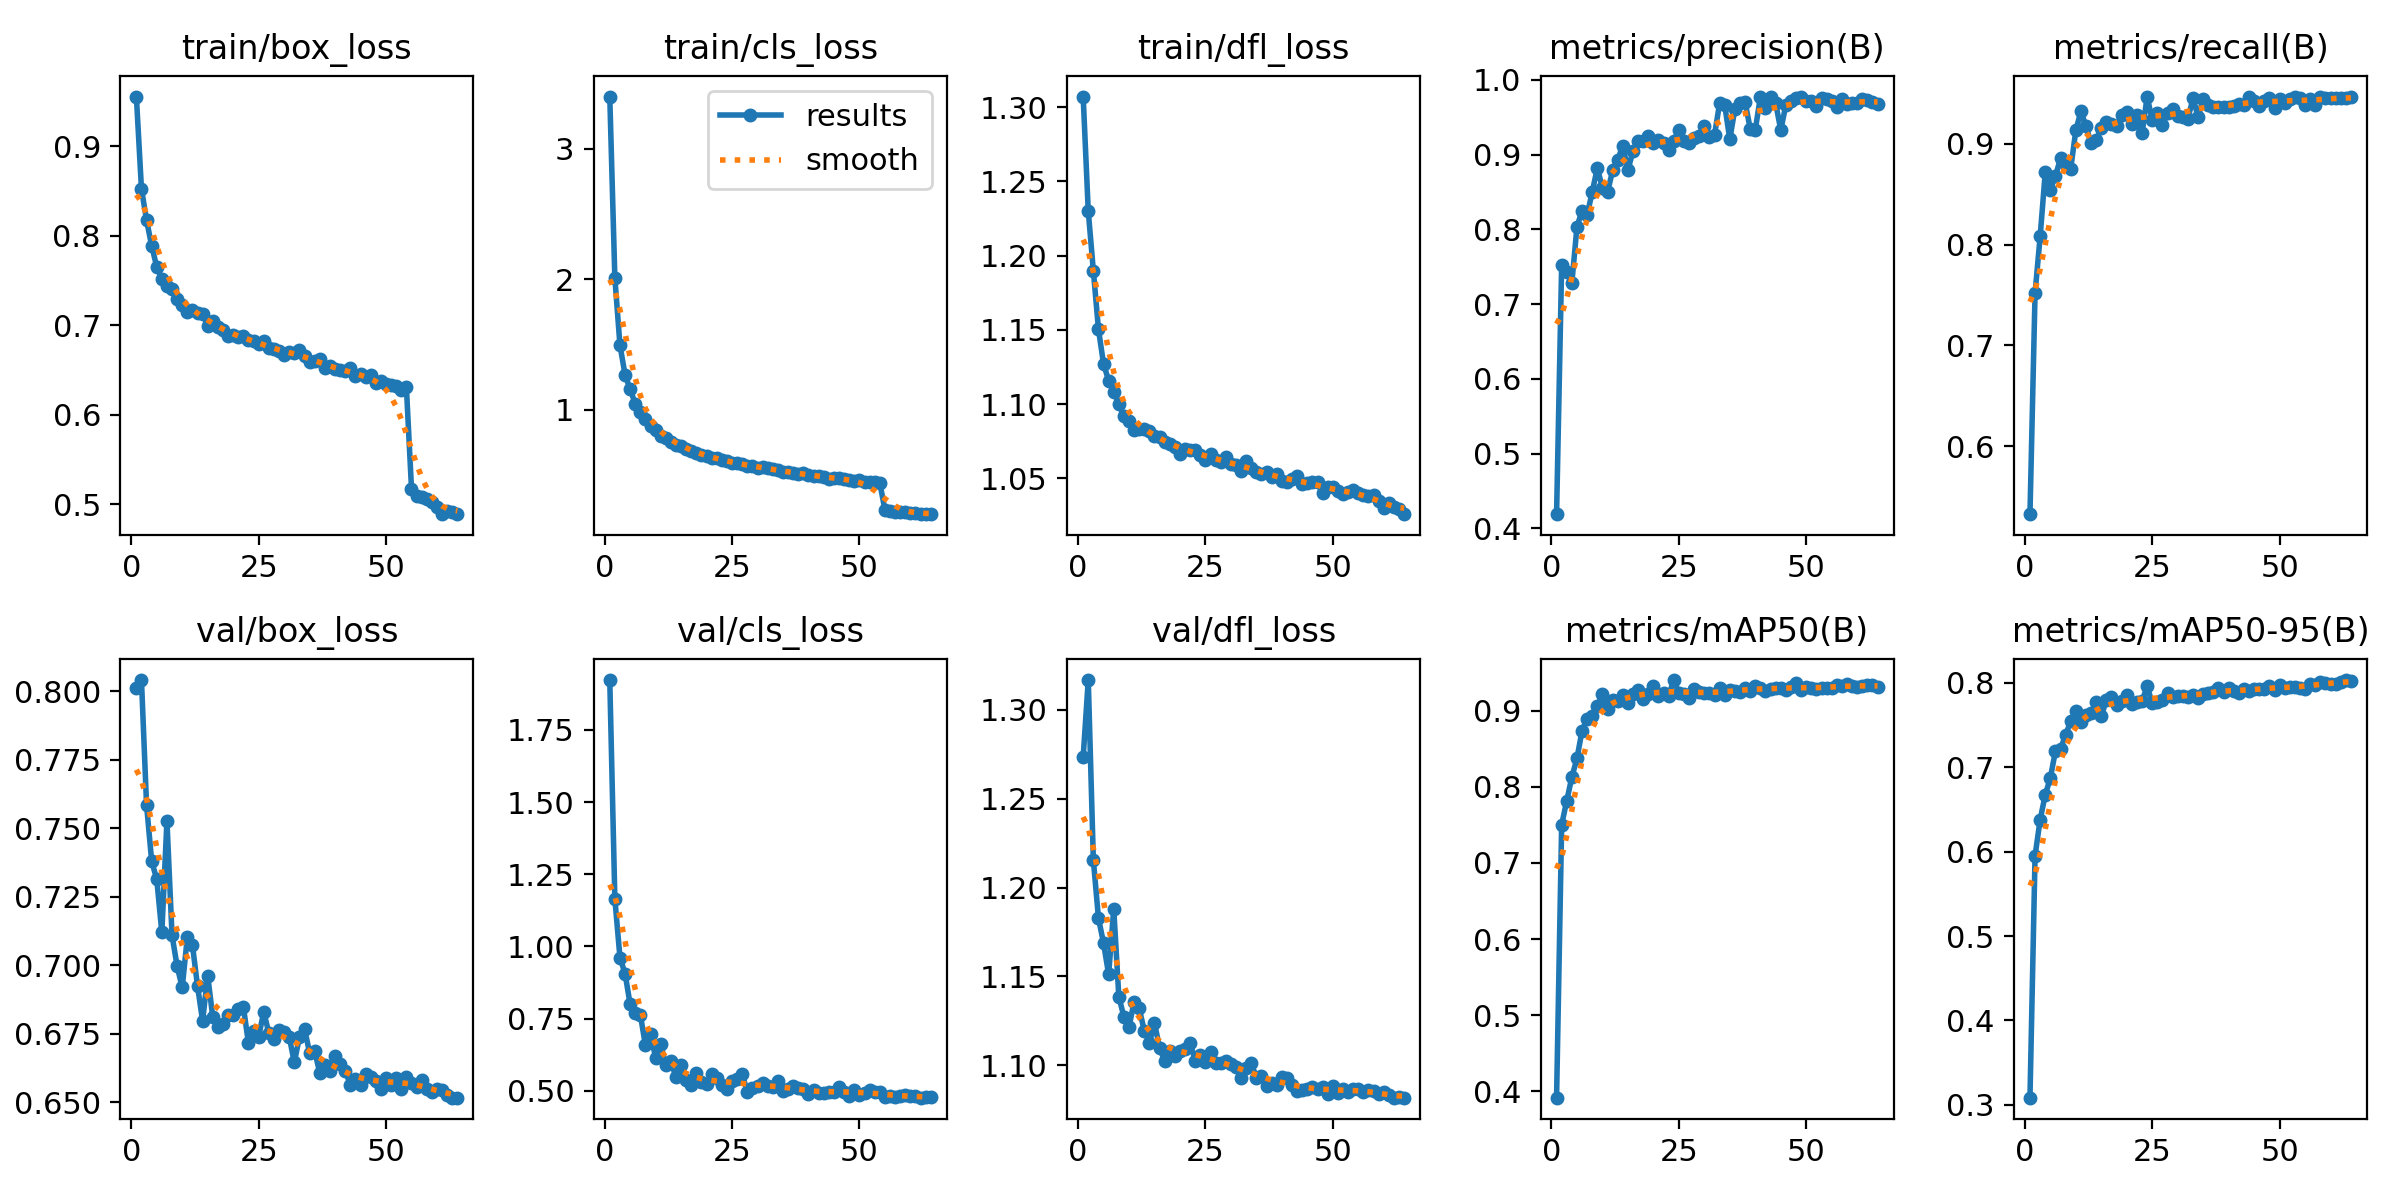

In [17]:
# Training results - visualized
image_path = '/content/datasets/results_yolov8_2.png'
display(Image(filename=image_path))

##### Evaluate performance on test set

In [ ]:
best_model_yolov8_experiment_2 = YOLO('/content/yolov8_project/yolov8_experiment_2/weights/best.pt')

In [21]:
yolov8_experiment_2_metrics = best_model_yolov8_experiment_2.val(data=data, imgsz=416, split = 'test', plots=True)

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/datasets/Traffic-and-Road-Signs-1/test/labels.cache... 1024 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1024/1024 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:06<00:00,  9.37it/s]


                   all       1024       1024      0.222       0.29      0.284      0.239
        No_Over_Taking         71         71          0          0          0          0
   Speed Limit 20 KMPh        140        140      0.667      0.871      0.853      0.716
   Speed Limit 30 KMPh        813        813          0          0          0          0
Speed: 0.3ms preprocess, 1.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val4


In [22]:
print("YOLOv8 Experiment 2 - Test Metrics")
print("-" * 40)
print(f"mAP (50-95): {yolov8_experiment_2_metrics.box.map:.4f}")
print(f"mAP50: {yolov8_experiment_2_metrics.box.map50:.4f}")
print(f"mAP75: {yolov8_experiment_2_metrics.box.map75:.4f}")
print(f"Mean Precision: {yolov8_experiment_2_metrics.box.mp: 4f}")
print(f"Mean Recall: {yolov8_experiment_2_metrics.box.mr: 4f}")

YOLOv8 Experiment 2 - Test Metrics
----------------------------------------
mAP (50-95): 0.2388
mAP50: 0.2842
mAP75: 0.2818
Mean Precision:  0.222388
Mean Recall:  0.290476


#### VI. Experiment 3: Training with batch size = 32

- **Project Name**: yolov8_project
- **Run Name**: yolov8_experiment_3
- **Training Parameters**:
  - **Data**: data
  - **Epochs**: 64
  - **Image Size (imgsz)**: 416
  - **Batch Size**: 32
  - **Save**: True
  - **Cache**: False
  - **Project**: yolov8_project
  - **Name**: yolov8_experiment_3
  - **Exist OK**: True
  - **Optimizer**: auto
  - **Seed**: 43
  - **Resume**: False

In [ ]:
# if mlflow.active_run():
#   mlflow.end_run()

In [ ]:
mlflow.set_experiment("yolov8_project")

<Experiment: artifact_location='mlflow-artifacts:/63672ef888a3488594cd09917737a7b2', creation_time=1724410911984, experiment_id='4', last_update_time=1724410911984, lifecycle_stage='active', name='yolov8_project', tags={}>

In [ ]:
train_params = {
    "data": data,
    "epochs": 64,
    "imgsz": 416,
    "batch": 32,
    "save": True,
    "cache": False,
    "project": "yolov8_project",
    "name": "yolov8_experiment_3",
    "exist_ok": True,
    "optimizer": "auto",
    "seed": 43,
    "resume": False
}

In [ ]:
val_params = {
    "batch": 32,
    "imgsz": 416,
}

In [ ]:
mlflow.system_metrics.enable_system_metrics_logging()

In [ ]:
best_model_path = '/content/yolov8_project/yolov8_experiment_3/weights/best.pt'
export_path = '/content/yolov8_project/yolov8_experiment_3/weights/best.onnx'

In [ ]:
model_experiment3 = YOLOV8(model_path="yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 122MB/s]


In [ ]:
model_experiment3.run(
    train_kwargs=train_params,
    best_model_path=best_model_path,
    val_kwargs=val_params,
    export_format="onnx",
    export_path=export_path,
    run_name="yolov8_experiment_3"
)

2024/08/27 04:53:12 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/Traffic-and-Road-Signs-1/data.yaml, epochs=64, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov8_project, name=yolov8_experiment_3, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_c

100%|██████████| 755k/755k [00:00<00:00, 22.1MB/s]


Overriding model.yaml nc=80 with nc=29

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/datasets/Traffic-and-Road-Signs-1/train/labels... 7092 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7092/7092 [00:03<00:00, 2140.75it/s]


train: New cache created: /content/datasets/Traffic-and-Road-Signs-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/Traffic-and-Road-Signs-1/valid/labels... 1884 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1884/1884 [00:01<00:00, 1232.34it/s]


val: New cache created: /content/datasets/Traffic-and-Road-Signs-1/valid/labels.cache
Plotting labels to yolov8_project/yolov8_experiment_3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000303, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/08/27 04:53:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/08/27 04:53:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/08/27 04:53:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(e32a1fad53404f13878bd43eaad16b66) to https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to yolov8_project/yolov8_experiment_3
Starting training for 64 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/64      1.97G     0.9754      3.533      1.319         52        416: 100%|██████████| 222/222 [01:10<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.30it/s]

                   all       1884       1886       0.32      0.525      0.316      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/64      1.89G     0.8424      2.059      1.217         54        416: 100%|██████████| 222/222 [01:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.29it/s]


                   all       1884       1886      0.728      0.719      0.722      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/64      1.97G     0.7936      1.461      1.174         58        416: 100%|██████████| 222/222 [01:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


                   all       1884       1886      0.748      0.834      0.788      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/64      1.97G      0.784      1.241      1.146         57        416: 100%|██████████| 222/222 [01:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.69it/s]

                   all       1884       1886      0.721      0.841      0.782      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/64      1.97G     0.7695      1.119      1.129         62        416: 100%|██████████| 222/222 [01:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


                   all       1884       1886      0.836      0.837      0.843      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/64      1.97G     0.7485      1.004      1.114         46        416: 100%|██████████| 222/222 [01:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.63it/s]


                   all       1884       1886      0.836      0.847      0.889      0.735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/64      1.97G     0.7382      0.936      1.105         54        416: 100%|██████████| 222/222 [01:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.01it/s]

                   all       1884       1886      0.804      0.891      0.895      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/64      1.97G     0.7294      0.893      1.097         60        416: 100%|██████████| 222/222 [01:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


                   all       1884       1886      0.816        0.9      0.905      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/64      1.97G     0.7252      0.834      1.095         63        416: 100%|██████████| 222/222 [01:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.79it/s]


                   all       1884       1886      0.867      0.907      0.899      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/64      1.97G     0.7239     0.8073      1.095         48        416: 100%|██████████| 222/222 [01:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.92it/s]

                   all       1884       1886      0.855      0.916       0.91      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/64      1.98G     0.7181     0.7646      1.089         60        416: 100%|██████████| 222/222 [01:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.90it/s]


                   all       1884       1886       0.88      0.913      0.916      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/64      1.97G     0.7167     0.7516      1.089         60        416: 100%|██████████| 222/222 [01:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.74it/s]


                   all       1884       1886      0.874      0.908      0.913      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/64      1.97G     0.7024     0.7273      1.082         58        416: 100%|██████████| 222/222 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]


                   all       1884       1886      0.893      0.921      0.916      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/64      1.97G     0.7114     0.7103      1.085         59        416: 100%|██████████| 222/222 [01:05<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.29it/s]


                   all       1884       1886      0.889      0.925      0.922      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/64      1.97G     0.6992      0.683      1.081         53        416: 100%|██████████| 222/222 [01:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.74it/s]

                   all       1884       1886      0.899      0.914      0.921      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/64      1.97G     0.6982     0.6631      1.078         49        416: 100%|██████████| 222/222 [01:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.99it/s]

                   all       1884       1886      0.902      0.923      0.921      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/64      1.97G     0.6953     0.6556      1.077         49        416: 100%|██████████| 222/222 [01:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.77it/s]


                   all       1884       1886      0.907      0.925      0.926       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/64      1.97G      0.687     0.6425      1.075         50        416: 100%|██████████| 222/222 [01:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


                   all       1884       1886      0.912      0.922      0.919      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/64      1.97G     0.6851     0.6211      1.073         68        416: 100%|██████████| 222/222 [01:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.32it/s]

                   all       1884       1886        0.9      0.924      0.916      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/64      1.97G     0.6873     0.6207      1.073         66        416: 100%|██████████| 222/222 [01:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.67it/s]


                   all       1884       1886       0.91       0.93      0.927      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/64      1.97G     0.6821     0.6122      1.071         56        416: 100%|██████████| 222/222 [01:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


                   all       1884       1886      0.904      0.919      0.908      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/64      1.97G     0.6818     0.6005      1.072         56        416: 100%|██████████| 222/222 [01:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.38it/s]


                   all       1884       1886      0.901      0.939      0.926      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/64      1.97G     0.6814     0.5931      1.073         53        416: 100%|██████████| 222/222 [01:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.74it/s]

                   all       1884       1886      0.883      0.914      0.898      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/64      1.97G     0.6768     0.5728      1.067         49        416: 100%|██████████| 222/222 [01:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.78it/s]

                   all       1884       1886      0.906      0.937      0.916      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/64      1.97G     0.6781     0.5743      1.066         49        416: 100%|██████████| 222/222 [01:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]

                   all       1884       1886      0.894      0.946      0.922      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/64      1.97G     0.6679     0.5607      1.066         51        416: 100%|██████████| 222/222 [01:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]


                   all       1884       1886      0.913      0.932      0.919      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/64      1.97G     0.6696     0.5598      1.065         61        416: 100%|██████████| 222/222 [01:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.21it/s]

                   all       1884       1886      0.927      0.928       0.92       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/64      1.97G      0.669     0.5451      1.065         55        416: 100%|██████████| 222/222 [01:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.81it/s]


                   all       1884       1886      0.946      0.938       0.92      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/64      1.97G     0.6626     0.5481      1.065         56        416: 100%|██████████| 222/222 [01:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.63it/s]

                   all       1884       1886       0.93      0.929      0.923      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/64      1.97G     0.6657     0.5331      1.065         53        416: 100%|██████████| 222/222 [01:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.40it/s]


                   all       1884       1886      0.964      0.935      0.924      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/64      1.97G     0.6628     0.5302      1.061         47        416: 100%|██████████| 222/222 [01:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


                   all       1884       1886      0.947      0.931      0.918      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/64      1.97G     0.6678     0.5282       1.06         47        416: 100%|██████████| 222/222 [01:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.63it/s]

                   all       1884       1886      0.902      0.949      0.915      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/64      1.97G     0.6634      0.521      1.062         44        416: 100%|██████████| 222/222 [01:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.36it/s]


                   all       1884       1886      0.962      0.941      0.925      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/64      1.97G     0.6544     0.5072      1.058         53        416: 100%|██████████| 222/222 [01:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.69it/s]

                   all       1884       1886      0.955      0.939      0.925      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/64      1.97G     0.6632     0.5069       1.06         46        416: 100%|██████████| 222/222 [01:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]

                   all       1884       1886      0.957      0.927      0.927       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/64      1.97G     0.6528     0.4967      1.056         57        416: 100%|██████████| 222/222 [01:03<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]

                   all       1884       1886      0.949      0.928       0.92      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/64      1.97G     0.6486     0.4933      1.052         54        416: 100%|██████████| 222/222 [01:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.74it/s]

                   all       1884       1886      0.965      0.933      0.923      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/64      1.97G     0.6484     0.4908      1.056         56        416: 100%|██████████| 222/222 [01:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.26it/s]

                   all       1884       1886      0.951      0.922      0.919      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/64      1.97G     0.6465     0.4857      1.053         49        416: 100%|██████████| 222/222 [01:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.76it/s]

                   all       1884       1886      0.962      0.934      0.927      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/64      1.97G     0.6491     0.4783      1.052         51        416: 100%|██████████| 222/222 [01:05<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.92it/s]

                   all       1884       1886      0.954      0.932      0.921      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/64      1.97G     0.6439      0.465       1.05         52        416: 100%|██████████| 222/222 [01:03<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.95it/s]

                   all       1884       1886      0.956      0.933      0.921      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/64      1.97G     0.6473     0.4657      1.053         56        416: 100%|██████████| 222/222 [01:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.74it/s]


                   all       1884       1886      0.968      0.931      0.922      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/64      1.97G     0.6396     0.4644      1.051         59        416: 100%|██████████| 222/222 [01:05<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.17it/s]

                   all       1884       1886      0.967      0.934      0.926      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/64      1.97G     0.6421     0.4593      1.052         66        416: 100%|██████████| 222/222 [01:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


                   all       1884       1886      0.964      0.935      0.926       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/64      1.97G     0.6401     0.4583      1.047         51        416: 100%|██████████| 222/222 [01:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]

                   all       1884       1886      0.971      0.932      0.922      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/64      1.97G     0.6343     0.4475      1.048         51        416: 100%|██████████| 222/222 [01:02<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.81it/s]

                   all       1884       1886      0.962      0.932      0.925      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/64      1.97G     0.6344     0.4446      1.047         61        416: 100%|██████████| 222/222 [01:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.71it/s]

                   all       1884       1886      0.964      0.932      0.929      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/64      1.96G     0.6357     0.4411      1.046         44        416: 100%|██████████| 222/222 [01:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]

                   all       1884       1886      0.972      0.933      0.927      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/64      1.97G     0.6255     0.4316      1.046         52        416: 100%|██████████| 222/222 [01:05<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.80it/s]

                   all       1884       1886       0.95      0.942      0.927      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/64      1.97G     0.6327      0.438      1.047         56        416: 100%|██████████| 222/222 [01:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.25it/s]

                   all       1884       1886      0.969      0.934      0.927      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/64      1.97G     0.6254     0.4234      1.044         53        416: 100%|██████████| 222/222 [01:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.71it/s]

                   all       1884       1886      0.962       0.93      0.921      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/64      1.97G     0.6293     0.4284      1.042         57        416: 100%|██████████| 222/222 [01:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

                   all       1884       1886      0.961      0.932      0.925      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/64      1.97G     0.6265     0.4227      1.044         41        416: 100%|██████████| 222/222 [01:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.90it/s]


                   all       1884       1886      0.963      0.931      0.925      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/64      1.97G     0.6263      0.422      1.043         58        416: 100%|██████████| 222/222 [01:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.66it/s]

                   all       1884       1886      0.969      0.932      0.925      0.792


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/64      1.97G     0.5141     0.2364      1.047         20        416: 100%|██████████| 222/222 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.20it/s]


                   all       1884       1886      0.958      0.939      0.929      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/64      1.97G     0.5056     0.2219      1.049         20        416: 100%|██████████| 222/222 [01:03<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.96it/s]

                   all       1884       1886      0.954      0.942      0.931      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/64      1.97G      0.504     0.2167      1.044         20        416: 100%|██████████| 222/222 [01:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.59it/s]

                   all       1884       1886      0.961      0.947      0.931      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/64      1.97G     0.4977     0.2156      1.043         20        416: 100%|██████████| 222/222 [01:01<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.99it/s]


                   all       1884       1886      0.965      0.942      0.935      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/64      1.97G     0.4974      0.213      1.041         20        416: 100%|██████████| 222/222 [01:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.03it/s]

                   all       1884       1886      0.967       0.94      0.932        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/64      1.97G     0.4911     0.2076      1.034         20        416: 100%|██████████| 222/222 [01:01<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:11<00:00,  2.71it/s]


                   all       1884       1886      0.978      0.941      0.932      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/64      1.97G     0.4869     0.2056       1.04         20        416: 100%|██████████| 222/222 [01:02<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


                   all       1884       1886      0.979      0.941      0.932        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/64      1.97G     0.4893     0.2042      1.034         20        416: 100%|██████████| 222/222 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.00it/s]


                   all       1884       1886      0.974      0.939      0.933      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/64      1.97G     0.4845      0.203      1.032         20        416: 100%|██████████| 222/222 [01:02<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.77it/s]

                   all       1884       1886      0.972       0.94      0.933      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/64      1.97G     0.4843     0.2005       1.03         20        416: 100%|██████████| 222/222 [01:02<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


                   all       1884       1886      0.978       0.94      0.933      0.803

64 epochs completed in 1.363 hours.
Optimizer stripped from yolov8_project/yolov8_experiment_3/weights/last.pt, 6.2MB
Optimizer stripped from yolov8_project/yolov8_experiment_3/weights/best.pt, 6.2MB

Validating yolov8_project/yolov8_experiment_3/weights/best.pt...
Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,011,303 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


                   all       1884       1886      0.965      0.942      0.935      0.803
-Road narrows on right         54         54      0.997          1      0.995      0.893
    50 mph speed limit         62         62       0.56          1      0.674      0.557
     Attention Please-        117        117          1          1      0.995      0.875
    Beware of children        106        106          1      0.998      0.995      0.881
CYCLE ROUTE AHEAD WARNING         54         54      0.998          1      0.995      0.864
Dangerous Left Curve Ahead         42         42      0.997          1      0.995      0.867
Dangerous Rright Curve Ahead         72         72          1      0.989      0.995      0.832
End of all speed and passing limits         48         48      0.997          1      0.995      0.846
              Give Way        107        107      0.999          1      0.995      0.849
Go Straight or Turn Right         79         79      0.999          1      0.995    

2024/08/27 06:16:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run yolov8_experiment_3 at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4/runs/e32a1fad53404f13878bd43eaad16b66.
2024/08/27 06:16:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4.
2024/08/27 06:16:07 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/08/27 06:16:07 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


MLflow: results logged to https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow
MLflow: disable with 'yolo settings mlflow=False'


2024/08/27 06:16:08 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/08/27 06:16:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run capable-cow-298 at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4/runs/ff439bb7214c438f9041485d5a2f8ece.
2024/08/27 06:16:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4.
2024/08/27 06:16:08 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/08/27 06:16:08 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,011,303 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/datasets/Traffic-and-Road-Signs-1/valid/labels.cache... 1884 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1884/1884 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.27it/s]


                   all       1884       1886      0.965      0.942      0.935      0.803
-Road narrows on right         54         54      0.997          1      0.995      0.893
    50 mph speed limit         62         62       0.56          1      0.674      0.556
     Attention Please-        117        117          1          1      0.995      0.875
    Beware of children        106        106          1      0.998      0.995      0.881
CYCLE ROUTE AHEAD WARNING         54         54      0.998          1      0.995      0.865
Dangerous Left Curve Ahead         42         42      0.997          1      0.995      0.871
Dangerous Rright Curve Ahead         72         72          1      0.989      0.995      0.835
End of all speed and passing limits         48         48      0.997          1      0.995      0.846
              Give Way        107        107      0.999          1      0.995       0.85
Go Straight or Turn Right         79         79      0.999          1      0.995    

2024/08/27 06:16:29 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/content/yolov8_project/yolov8_experiment_3/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 33, 3549) (5.9 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 292.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.2s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.2 opset 19...
ONNX: export success ✅ 5.8s, saved as '/content/yolov8_project/yolov8_experiment_3/weights/best.onnx' (11.6 MB)

Export complete (7.4s)
Results saved to /content/yolov8_project/yolov8_experiment_3/weights
Predict:         yolo predict task=detect model=/content/yolov8_project/yolov8_experiment_3/weights/best.onnx imgsz=416  
Validate:        yolo val task=detect mo

2024/08/27 06:16:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run rogue-hen-59 at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4/runs/9832e2d880824613aea0190018d98831.
2024/08/27 06:16:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/shefali.0695/Object-detection-using-YOLOv8-and-RT-DETR.mlflow/#/experiments/4.
2024/08/27 06:16:38 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/08/27 06:16:38 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


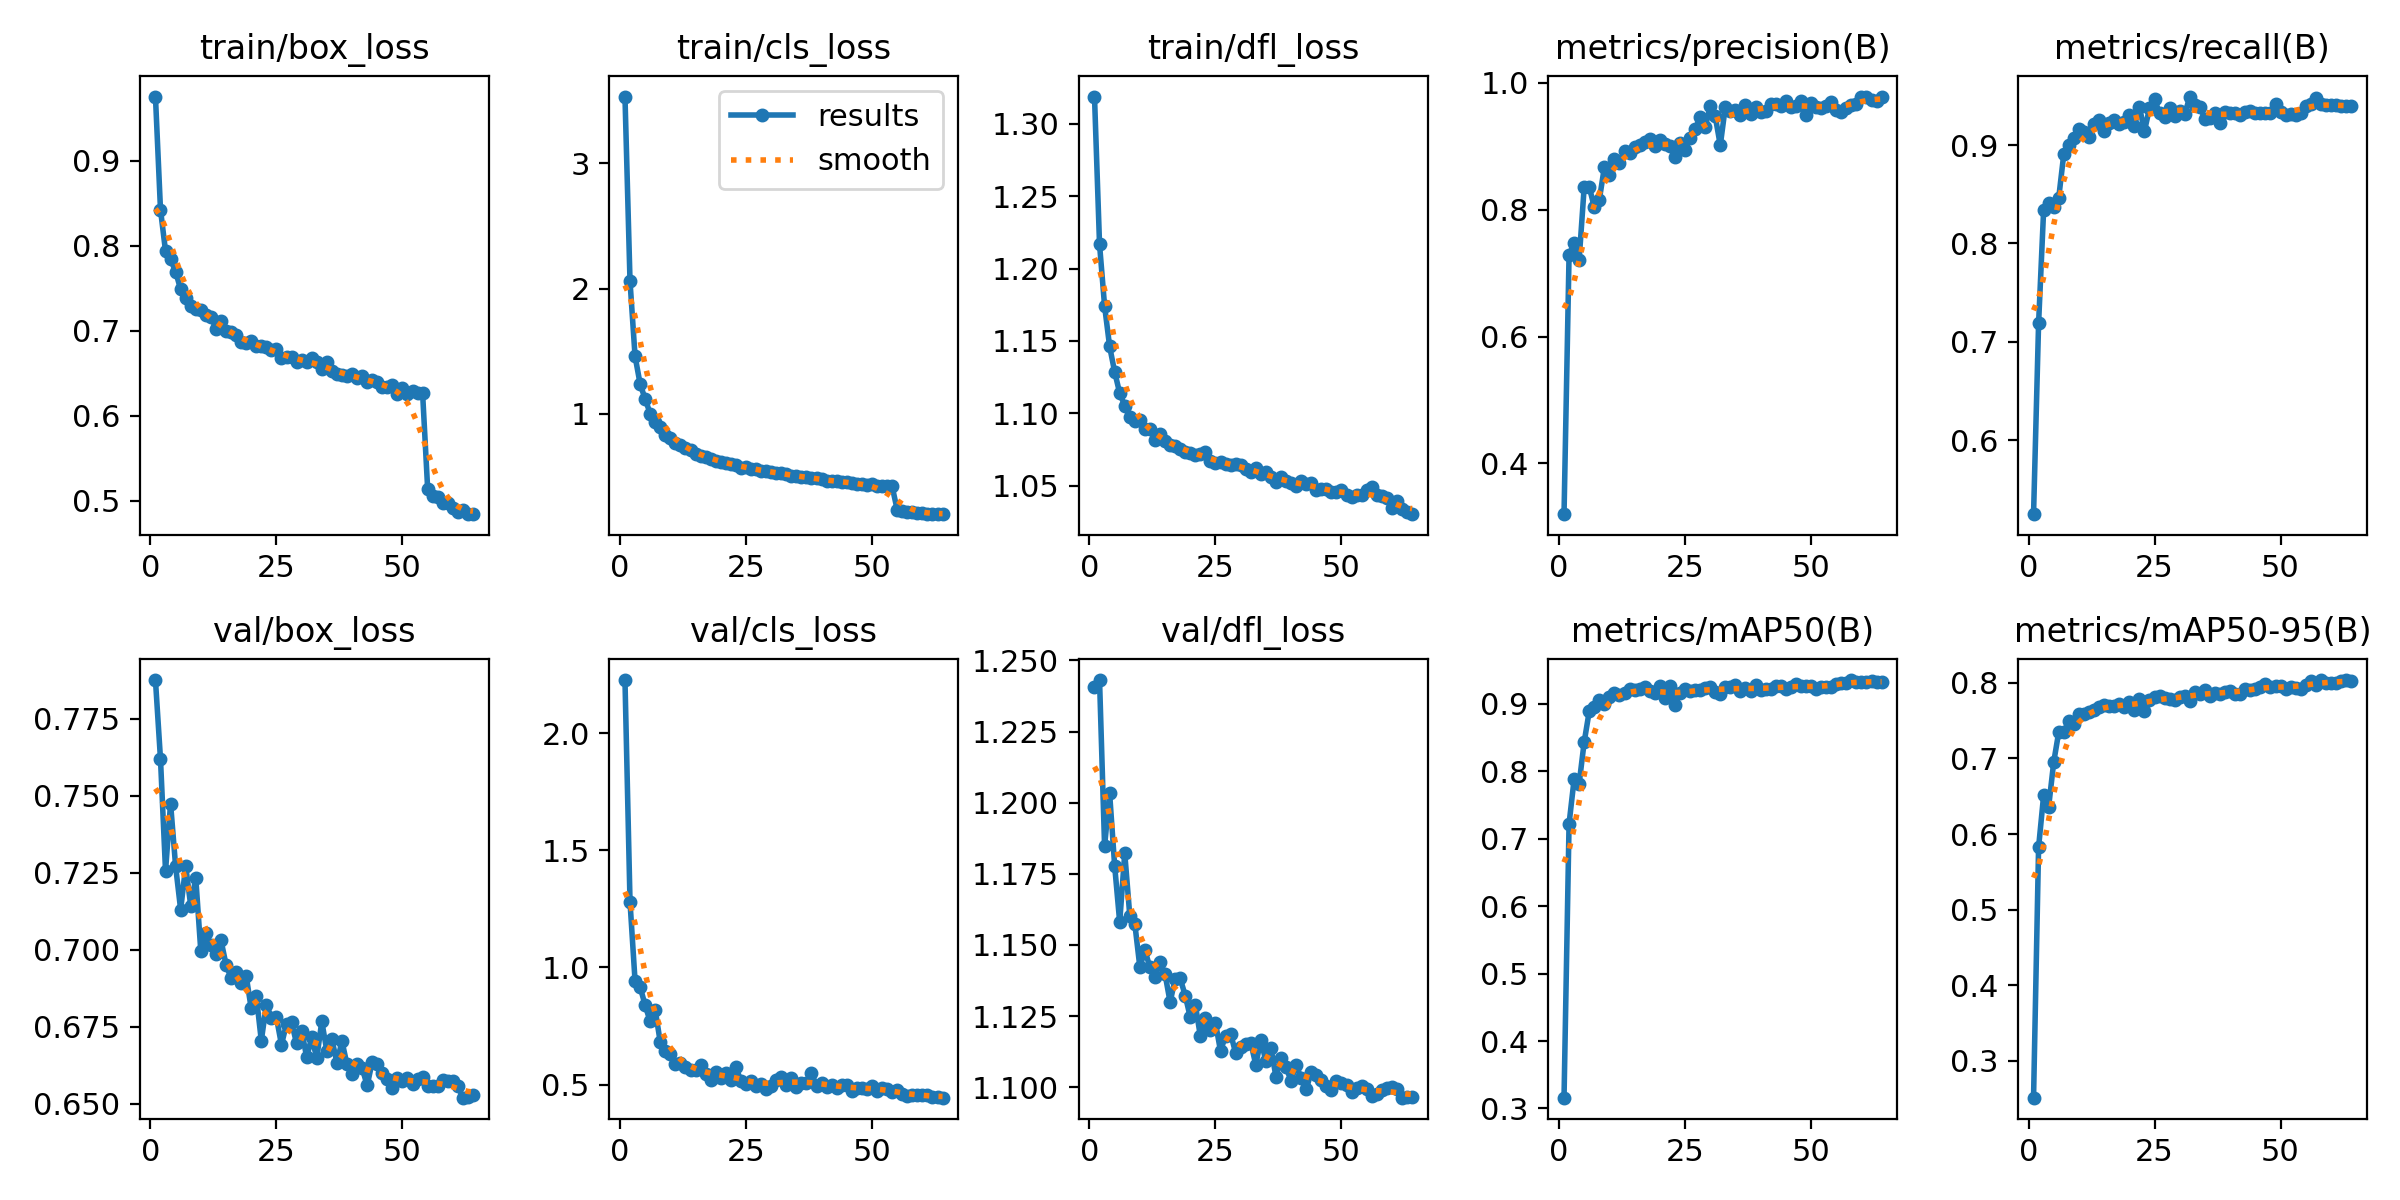

In [29]:
# Training results - visualized
image_path = '/content/datasets/results_yolov8_3.png'
display(Image(filename=image_path))

##### Evaluate performance on test set

In [ ]:
# Check performance on test set
best_model_yolov8_experiment_3 = YOLO('/content/yolov8_project/yolov8_experiment_3/weights/best.pt')

In [28]:
yolov8_experiment_3_metrics = best_model_yolov8_experiment_3.val(data=data, imgsz=416, split = 'test', plots=True)

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,011,303 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/datasets/Traffic-and-Road-Signs-1/test/labels.cache... 1024 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1024/1024 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.68it/s]


                   all       1024       1024       0.21      0.283      0.283      0.236
        No_Over_Taking         71         71          0          0          0          0
   Speed Limit 20 KMPh        140        140      0.629      0.848      0.849      0.709
   Speed Limit 30 KMPh        813        813          0          0          0          0
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val5


In [30]:
print("YOLOv8 Experiment 3 - Test Metrics")
print("-" * 40)
print(f"mAP (50-95): {yolov8_experiment_3_metrics.box.map:.4f}")
print(f"mAP50: {yolov8_experiment_3_metrics.box.map50:.4f}")
print(f"mAP75: {yolov8_experiment_3_metrics.box.map75:.4f}")
print(f"Mean Precision: {yolov8_experiment_3_metrics.box.mp: 4f}")
print(f"Mean Recall: {yolov8_experiment_3_metrics.box.mr: 4f}")

YOLOv8 Experiment 3 - Test Metrics
----------------------------------------
mAP (50-95): 0.2365
mAP50: 0.2831
mAP75: 0.2806
Mean Precision:  0.209720
Mean Recall:  0.282764
